## 카카오톡 대화 주제 분류 모델
- DB에서 데이터를 가지고 와서 학습 시키기

In [1]:
# 모듈 로딩
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

from konlpy.tag import *
from custom import *

import os
import pickle

import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MySQL 연결 설정
connection = pymysql.connect(
    host= '172.20.60.151',      # MySQL 서버 주소
    user='hyunju',
    password='1234',
    db='web_project',
)

try:
    query_mil = "SELECT * FROM military"  
    militaryDF = pd.read_sql(query_mil, connection)

    query_food = "SELECT * FROM food"  
    foodDF = pd.read_sql(query_food, connection)

finally:
    # 연결 종료
    connection.close()

C:\Users\kdp\AppData\Local\Temp\ipykernel_21800\2587438357.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  militaryDF = pd.read_sql(query_mil, connection)
C:\Users\kdp\AppData\Local\Temp\ipykernel_21800\2587438357.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  foodDF = pd.read_sql(query_food, connection)


In [3]:
foodDF

,id,category,text
0,0,식음료,배 아프면 약국 가서 소 화제 라도 마시는 거 어때
1,1,식음료,얼마나 먹었다고 배 아프데
2,2,식음료,떡볶이 랑 튀김 이랑 닭 껍질 튀김 이랑 마카롱 먹었어
3,3,식음료,하긴 배는 파리 보다 작으니까 당연히 그만큼 먹어도 배부르지
4,4,식음료,아닌데 많이 먹은 거 같은데
...,...,...,...
67436,67436,식음료,이름 부터 이상하긴 하다
67437,67437,식음료,우선 음료 이상하고 크림 위 뿌려진 가루 별로
67438,67438,식음료,할로윈 이라 호박 음료 출시 한 건가
67439,67439,식음료,한국 정서 와는 안 어울리는 것 같아


In [4]:
militaryDF

,id,category,text
0,0,군대,군인 들 은 산재 처리 되나
1,1,군대,엄청 많이 다치잖아
2,2,군대,군인 들 은 나라 사랑 카드 발급 받으면 최대 만원 까지 보험 처리 되는데 죽어야 ...
3,3,군대,군인 산재 어딨냐 걍 국군 병원 고고 지
4,4,군대,죽어야 나중 아들 낳으면 꽁꽁 숨겨 놔야지 안되겠어
...,...,...,...
55012,55012,군대,여자친구 고 무신 거꾸로 안 신고 이쁘게 사랑 했으면 좋겠네
55013,55013,군대,다른사람 만나지 않게 휴가 나와서 잘해야 지
55014,55014,군대,추억 생각나고 풋풋 해보여서 까지 기분 좋더라
55015,55015,군대,군생활 중 별 통보 제일 슬프다던데 잘 해줘야지


In [5]:
# 데이터프레임 합치기 + 카테고리, 텍스트 열만 사용
dataDF = pd.concat([foodDF, militaryDF],ignore_index=True)[['category','text']]
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122458 entries, 0 to 122457
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  122458 non-null  object
 1   text      122458 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [6]:
# 카테고리 데이터 : 텍스트 => 정수로 변경
dataDF['category'] = dataDF['category'].replace({'군대':0, '식음료':1})
dataDF.tail()

,category,text
122453,0,여자친구 고 무신 거꾸로 안 신고 이쁘게 사랑 했으면 좋겠네
122454,0,다른사람 만나지 않게 휴가 나와서 잘해야 지
122455,0,추억 생각나고 풋풋 해보여서 까지 기분 좋더라
122456,0,군생활 중 별 통보 제일 슬프다던데 잘 해줘야지
122457,0,군대 생활 에서 여자친구 생각 하면서 버티면 그나마 힘 될꺼야


In [7]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122458 entries, 0 to 122457
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  122458 non-null  int64 
 1   text      122458 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [8]:
# 훈련, 검증용 데이터 나누기
train = dataDF.sample(frac=0.8, random_state=10)
val = dataDF.drop(train.index)

print(train.head(5).to_markdown())
print(len(train), len(val))

|        |   category | text                         |
|-------:|-----------:|:-----------------------------|
|  15025 |          1 | 칼국수 땡기 기는 한데        |
| 116477 |          0 | 위드 코로나                  |
|  50292 |          1 | 고기 같이 먹어 주는게 좋은데 |
|  78979 |          0 | 가능하지                     |
|  42520 |          1 | 비꼬 카레 제일 낫더라        |
97966 24492


In [9]:
# 데이터 토큰화 및 단어사전 구축
tokenizer = Okt()

In [10]:
train_tokens = [tokenizer.morphs(sentence) for sentence in train.text]
val_tokens = [tokenizer.morphs(sentence) for sentence in val.text]
print(f'train : {len(train_tokens)}, valid : {len(val_tokens)}')

train : 97966, valid : 24492


In [11]:
vocab = build_vocab(corpus=train_tokens, n_vocab=10000, special_tokens=["<PAD>","<UNK>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
it_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<PAD>', '<UNK>', '은', '안', '군대', '거', '들', '에서', '뭐', '잘']
10002


In [12]:
# 단어 사전 저장
import pickle
with open('./vocab_okt.pkl', 'wb') as f:
	pickle.dump(token_to_id, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


(array([6.8439e+04, 2.6648e+04, 2.5570e+03, 2.7100e+02, 4.1000e+01,
        3.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49.]),
 <BarContainer object of 8 artists>)

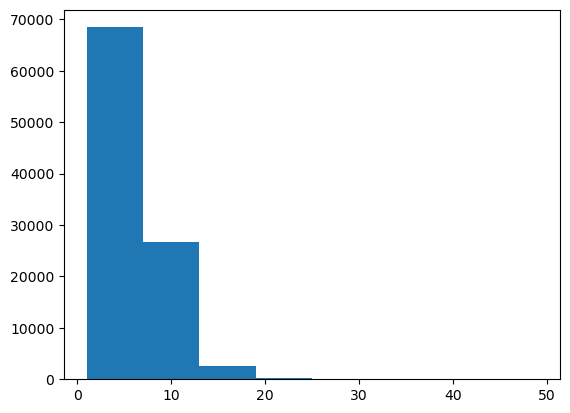

In [13]:
# 패딩 적정 길이 찾기
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=8)

(array([24976., 43463., 15808.,  9456.,  2864.,   742.,   430.,   134.]),
 array([ 1.   ,  3.625,  6.25 ,  8.875, 11.5  , 14.125, 16.75 , 19.375,
        22.   ]),
 <BarContainer object of 8 artists>)

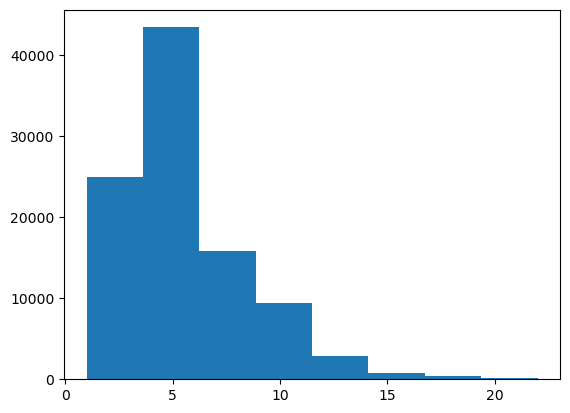

In [14]:
# 패딩 적정 길이 찾기
datalen_22 = [len(tokens) for tokens in train_tokens if len(tokens) <=22]
plt.hist(datalen_22, bins=8)

In [15]:
# 정수 인코딩 및 패딩
unk_id = token_to_id['<UNK>']
train_ids = [[token_to_id.get(token, unk_id)for token in text] for text in train_tokens]
val_ids = [[token_to_id.get(token, unk_id)for token in text] for text in val_tokens]

max_length = 20
pad_id = token_to_id['<PAD>']
train_ids = pad_sequences(train_ids, max_length, pad_id)
val_ids = pad_sequences(val_ids, max_length, pad_id)

print(train_ids[0])
print(val_ids[0])

[ 709 7170 1792  426    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[ 202   39  584   58  406 2631  584   58  641   68    0    0    0    0
    0    0    0    0    0    0]


In [16]:
# 데이터로더 적용
batch_size=32
train_ids = torch.tensor(train_ids)
val_ids = torch.tensor(val_ids)

train_labels = torch.tensor(train.category.values, dtype=torch.float32)
val_labels = torch.tensor(val.category.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
val_dataset = TensorDataset(val_ids, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# 손실함수와 최적화 함수 정의
n_vocab = len(token_to_id)
hidden_dim = 8
embedding_dim = 128
n_layers = 2
model_type = 'lstm'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, 
                                embedding_dim=embedding_dim, n_layers=n_layers, model_type=model_type).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.01)
# 최적화 스케줄링 인스턴스 생성
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

c:\Users\kdp\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [18]:
# 저장 경로
SAVE_PATH = './models/'
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성

In [19]:
# ----------------------------------------------------------------------------
# 모델 학습 및 테스트
# ----------------------------------------------------------------------------
def train_model(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    f1scores = list()
    accuracy = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        train_score = BinaryF1Score()(logits, labels)
        f1scores.append(train_score)

        train_acc = BinaryAccuracy()(logits, labels)
        accuracy.append(train_acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step% interval == 0:
            print(f'Train {step} Loss : {np.mean(losses)} Accuracy : {np.mean(accuracy)}')

def test_model(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    f1scores = list()
    accuracy = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        val_score = BinaryF1Score()(logits, labels)
        f1scores.append(val_score)

        val_acc = BinaryAccuracy()(logits, labels)
        accuracy.append(val_acc)
        
        yhat = torch.sigmoid(logits)>.5
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())
    print('-'*100)
    print(f"Validation Loss : {np.mean(losses)} Accuracy : {np.mean(accuracy)}")
    return np.mean(losses), np.mean(accuracy)

In [20]:
epochs = 50
interval = 500
for epoch in range(epochs):
    print(f'[{epoch+1}/{epochs}]')
    train_model(classifier, train_loader, criterion, optimizer, device, interval)
    loss_val, score_val = test_model(classifier,val_loader, criterion, device)

    # 최적화 스케줄러 인스턴스 업데이트
    scheduler.step(score_val)
    print(f'scheduler.num_bad_epochs => {scheduler.num_bad_epochs}\n')

    SAVE_MODEL = SAVE_PATH + f'ltsm2_loss{loss_val:.3f}_acc{score_val:.3f}.pth'
    torch.save(classifier, SAVE_MODEL)

    if scheduler.num_bad_epochs >= scheduler.patience :
        print(f'성능 개선이 없어서 {epoch+1} EPOCH에 조기 종료함!')
        break

[1/50]
Train 0 Loss : 0.7010743021965027 Accuracy : 0.5
Train 500 Loss : 0.6742204126721608 Accuracy : 0.5418537855148315
Train 1000 Loss : 0.6358876246493775 Accuracy : 0.6097028255462646
Train 1500 Loss : 0.598737741116283 Accuracy : 0.6593729257583618
Train 2000 Loss : 0.5655157492048797 Accuracy : 0.6924037933349609
Train 2500 Loss : 0.5400094674115942 Accuracy : 0.714326798915863
Train 3000 Loss : 0.5195936582428898 Accuracy : 0.7298712730407715
----------------------------------------------------------------------------------------------------
Validation Loss : 0.3553646059011355 Accuracy : 0.8332926034927368
scheduler.num_bad_epochs => 0

[2/50]
Train 0 Loss : 0.4540441334247589 Accuracy : 0.71875
Train 500 Loss : 0.37687959229041956 Accuracy : 0.8322729468345642
Train 1000 Loss : 0.37688471975324156 Accuracy : 0.8339473009109497
Train 1500 Loss : 0.3735084832806654 Accuracy : 0.8360468149185181
Train 2000 Loss : 0.3698796742353244 Accuracy : 0.838736891746521
Train 2500 Loss : 

#### 예측하기

In [30]:
# 모델 로딩
SAVE_MODEL = "./models/ltsm_loss0.304_acc0.866.pth"
model = torch.load(SAVE_MODEL)

In [45]:
data = '맞아 습도! 안 그래도 제습기 사려고 상품 페이지 보고 있었어 키키'
text = re.sub(r'[^\가-힣\s]', '', data)
print(text)

맞아 습도 안 그래도 제습기 사려고 상품 페이지 보고 있었어 키키


In [46]:
# 불용어처리
stopwords= ['키키', '아', '나', '는', '그래', '응', '응응', '휴', '어휴', '에고', '야', '진짜', '엉', '웅', '하하', '너', '가', '든', 
        '앜', '헐', '어', '여기', '에', '다', '아니', '근데', '악', '히익', '챡챡챡챡', '으', '도', '네', '넵', '오', '그냥', 
        '그럼', '그거', '그러네','그러게', '헐', '엥', '음', '을', '이', '와', '역시', '어어', '그래도', '맞아', '그', '막', 
        '그렇지', '넹', '어머', '하', '우와', '오호', '오오','와우']

In [47]:
# 단어사전 로드
with open('vocab_okt.pkl', 'rb') as f:
    vocab = pickle.load(f)

print(vocab)

{'<PAD>': 0, '<UNK>': 1, '은': 2, '안': 3, '군대': 4, '거': 5, '들': 6, '에서': 7, '뭐': 8, '잘': 9, '것': 10, '나도': 11, '난': 12, '많이': 13, '한': 14, '해': 15, '너무': 16, '를': 17, '만': 18, '내': 19, '때': 20, '로': 21, '못': 22, '먹어': 23, '먹고': 24, '더': 25, '오늘': 26, '같아': 27, '으로': 28, '맛': 29, '좀': 30, '우리': 31, '요즘': 32, '게': 33, '생각': 34, '사람': 35, '하고': 36, '하는': 37, '말': 38, '랑': 39, '집': 40, '그런': 41, '고': 42, '엄청': 43, '지': 44, '이야': 45, '밥': 46, '왜': 47, '할': 48, '있어': 49, '수': 50, '요': 51, '군인': 52, '지금': 53, '저녁': 54, '좋아': 55, '배달': 56, '그래서': 57, '이랑': 58, '거기': 59, '의': 60, '같이': 61, '해서': 62, '치킨': 63, '저': 64, '봐': 65, '하면': 66, '정말': 67, '먹었어': 68, '음식': 69, '거야': 70, '친구': 71, '또': 72, '커피': 73, '일': 74, '면': 75, '점심': 76, '적': 77, '한번': 78, '먹는': 79, '이제': 80, '그렇게': 81, '전': 82, '인데': 83, '라고': 84, '애': 85, '서': 86, '훈련': 87, '듯': 88, '아침': 89, '시간': 90, '걸': 91, '라': 92, '군': 93, '보다': 94, '먹을': 95, '무슨': 96, '그건': 97, '시켜': 98, '가서': 99, '있는': 100, '정도': 101, '완전': 102, '알': 103, '

In [48]:
tokenizer = Okt()
tokenList = [token for token in tokenizer.morphs(text) if token not in stopwords]
print(tokenList)

['습도', '안', '제습기', '사려', '고', '상품', '페이지', '보고', '있었어']


In [49]:
for idx, token in enumerate(tokenList):
    if token not in vocab.keys():
        tokenList[idx] = '<UNK>'
        
print(tokenList)

['<UNK>', '안', '<UNK>', '사려', '고', '상품', '<UNK>', '보고', '있었어']


In [50]:
max_length = 20

inputs = [vocab[token] for token in tokenList]

# 최대 길이 맞추기
if len(inputs) < max_length:
    inputs += [vocab['<PAD>'] * (max_length - len(inputs))]
else :
    inputs = inputs[:max_length]

# 텐서 변환
input_tensor = torch.tensor(inputs).unsqueeze(0)

In [51]:
# 예측
model.eval()

with torch.no_grad():
    
	# 추론/평가
    pre_y = model(input_tensor)
    print(pre_y)
    
	# 예측 결과 처리 (logits를 확률로 변환)
    probability = torch.sigmoid(pre_y).item()
    
    # 결과 출력 (임계값을 0.5로 설정해 분류)
    if probability > 0.5:
        result =  "음식🤤"
    else:
        result =  "음식 아님!"
        
print(f'대화주제:{result}, 주제가 음식일 확률:{probability*100 :.1f}%')

tensor([[-1.9258]])
대화주제:음식 아님!, 주제가 음식일 확률:12.7%
